<h3>Connect Google Drive</h3>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


<h3>Packages</h3>

In [ ]:
import torch
import torchvision
from PIL import Image, ImageDraw
from torchvision import models
from torch.nn import functional as F
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torchvision import utils
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import imagesize
from torch.utils import data
import torch.optim as optim
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
import os
from pathlib import Path
import pandas as pd
from torch.utils.data import SubsetRandomSampler,DataLoader,Dataset
from google.colab.patches import cv2_imshow

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
dataset_folder = '/content/gdrive/MyDrive/Cancer4/400X'
img_path = '/content/gdrive/MyDrive/Cancer4/400X/test/Benign/SOB_B_F-14-21998CD-400-005.png'
training_dataset_path = '/content/gdrive/MyDrive/Cancer4/400X/train'
testing_dataset_path = '/content/gdrive/MyDrive/Cancer4/400X/test'
classes = sorted(os.listdir(dataset_folder + '/train'))
print(classes)

['Benign', 'Malignant']


In [ ]:
img = Image.open(img_path)

In [ ]:
classes

['Benign', 'Malignant']

In [ ]:
np.random.seed(0)
torch.manual_seed(0)

In [ ]:
def image_transform():
  transform = transforms.Compose([
    transforms.Resize((512,512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.7590, 0.5809, 0.7404],std = [0.1195, 0.1602, 0.0887])
    ])
  return transform

In [ ]:
transform = image_transform()

In [ ]:
def load_dataset(path,transform_img):
  data = torchvision.datasets.ImageFolder(root=path, transform=transform)
  return data

In [ ]:
training_dataset = load_dataset(training_dataset_path,transform)
training_dataset

Dataset ImageFolder
    Number of datapoints: 1166
    Root location: /content/gdrive/MyDrive/Cancer4/400X/train
    StandardTransform
Transform: Compose(
               Resize(size=(512, 512), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.759, 0.5809, 0.7404], std=[0.1195, 0.1602, 0.0887])
           )

In [ ]:
testing_dataset = load_dataset(testing_dataset_path,transform)
testing_dataset

Dataset ImageFolder
    Number of datapoints: 657
    Root location: /content/gdrive/MyDrive/Cancer4/400X/test
    StandardTransform
Transform: Compose(
               Resize(size=(512, 512), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.759, 0.5809, 0.7404], std=[0.1195, 0.1602, 0.0887])
           )

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset = training_dataset, batch_size = 16,shuffle=True)

In [ ]:
  #Splitting Training Data into Training and Validation

dataset_size = len(testing_dataset)
dataset_indices = list(range(dataset_size))
np.random.shuffle(dataset_indices)
val_split_index = int(np.floor(0.3 * dataset_size)) #0.2 - 30:70 Ratio
train_idx, val_idx = dataset_indices[val_split_index:], dataset_indices[:val_split_index]
test_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)
test_loader = torch.utils.data.DataLoader(dataset = testing_dataset,batch_size = 16,sampler=test_sampler,shuffle=False)
val_loader = DataLoader(dataset= testing_dataset, shuffle=False, batch_size=16, sampler=val_sampler)

<h3>Training Model</h3>

In [ ]:
model = torchvision.models.mobilenet_v2(pretrained=True)

In [ ]:
model = model.to(device)

In [ ]:
#Output Layer Modification
num_ftrs = model.classifier[1].in_features
num_classes = 2
model.classifier[1] = nn.Linear(num_ftrs, num_classes)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9,weight_decay = 0.03)

In [ ]:
X = transform(img).unsqueeze_(0)

In [ ]:
def set_device():
  if torch.cuda.is_available():
    dev = 'cuda:0'
  else:
    dev = 'cpu'
  return torch.device(dev)

In [ ]:
def train_nn(model, train_loader, test_loader,criterion,optimizer,n_epochs):
  device = set_device()
  best_acc = 0
  train_losses = []
  train_acc = []
  val_acc = []
  val_losses = []
  model = model.to(device)
  for epoch in range(n_epochs):
    print("Epoch number: %d"%(epoch+1))
    model.train()
    running_loss = 0.0
    running_correct = 0.0
    total = 0
    for data in train_loader:
      images,labels = data
      images = images.to(device) #for faster processing
      labels = labels.to(device)
      total += labels.size(0)

      optimizer.zero_grad() #Set grad = 0 before back prop
      outputs = model(images)

      _,predicted = torch.max(outputs.data,1)

      loss = criterion(outputs,labels)
      loss.backward() #Calculate Weight gradients
      optimizer.step() #update weights
      running_loss += loss.item()
      running_correct += (labels==predicted).sum().item()



    epoch_loss = running_loss/len(train_loader)
    epoch_acc = 100.0*running_correct/total
    train_losses.append(epoch_loss)
    train_acc.append(epoch_acc)

    print("  -Training Dataset, Got %d out of %d images correctly (%0.3f%%). Epoch Loss: %0.3f"%(running_correct, total, epoch_acc,epoch_loss))
    test_dataset_acc, test_dataset_loss = evaluate_model(model,test_loader,criterion)
    val_acc.append(test_dataset_acc)
    val_losses.append(test_dataset_loss)

    if (test_dataset_acc>best_acc):
        best_acc = test_dataset_acc
        save_checkpoint(model,epoch,optimizer,best_acc)

  print('Finished Training')
  return model,train_losses,train_acc,val_acc,val_losses

In [ ]:
def save_checkpoint(model,epoch,optimizer, best_acc):
  state = {
      'epoch': epoch + 1,
      'model': model.state_dict(),
      'best accuracy': best_acc,
      'optimizer': optimizer.state_dict(),
  }
  torch.save(state,'/content/gdrive/MyDrive/Cancer/model/mobilenet_v2_cancerend_latest.pth')

In [ ]:
def evaluate_model(model,test_loader,criterion):
    model.eval()
    predicted_correctly = 0
    total = 0
    device = set_device()
    running_loss = 0.0

    with torch.no_grad(): #Used for not backpropogating which improves computation speed
          for data in test_loader:
            images,labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0) #total amount of images

            outputs = model(images)

            _,predicted = torch.max(outputs.data,1)
            loss = criterion(outputs,labels)
            running_loss+=loss.item()

            predicted_correctly+=(predicted==labels).sum().item()
    epoch_acc = 100.0*predicted_correctly/total
    epoch_loss = running_loss/len(test_loader)
    print('-  Testing dataset. Got %d out of %d images correctly (%0.3f%%). Loss: %0.3f' % (predicted_correctly, total, epoch_acc,epoch_loss))

    return epoch_acc,epoch_loss


In [ ]:
#Train the model
#history, train_losses, train_acc, val_acc, val_losses = train_nn(model, train_loader,val_loader, criterion, optimizer_ft ,100)

Load the Model

In [ ]:
model_path = '/content/gdrive/MyDrive/Models/400X_mobilenet_model.pth'
check = torch.load(model_path,map_location=torch.device(device)) #model in dictionary

In [ ]:
check['best accuracy'] #Print best model accuracy during training

86.73469387755102

In [ ]:
#Extract model from dictionary and save it in a dir
model.load_state_dict(check['model'])
#torch.save(model,'/content/gdrive/MyDrive/Cancer/model/mobilenet_v2_cancerend_nil.pth')

<All keys matched successfully>

In [ ]:
def set_model(model,device):
  model = model.to(device)
  model.eval()
  return model

In [ ]:
mobilenet_model = set_model(model,device)

In [ ]:
def evaluate_model(model,test_loader,criterion):
    model.eval()
    predicted_correctly = 0
    total = 0
    device = set_device()
    running_loss = 0.0
    with torch.no_grad(): #Used for not backpropogating which improves computation speed
          for data in test_loader:
            images,labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0) #total amount of images

            outputs = model(images)

            _,predicted = torch.max(outputs.data,1)
            loss = criterion(outputs,labels)
            running_loss+=loss.item()

            predicted_correctly+=(predicted==labels).sum().item()
    epoch_acc = 100.0*predicted_correctly/total
    epoch_loss = running_loss/len(test_loader)
    print('-  Testing dataset. Got %d out of %d images correctly (%0.3f%%). Loss: %0.3f' % (predicted_correctly, total, epoch_acc,epoch_loss))
    return epoch_acc,epoch_loss

In [ ]:
#evaluate_model(mobilenet_model,test_loader,criterion)

<h3>Test Model</h3>

In [ ]:
img_path = '/content/SOB_B_A-14-29960CD-400-012.png'

In [ ]:
img = Image.open(img_path)

In [ ]:
def classify(model,image_transforms,image_path, classes,device):
  model = set_model(model,device)
  image = Image.open(image_path)
  image = image_transforms(image).to(device)
  image = image.unsqueeze(0)
  output = model(image)
  _,predicted = torch.max(output,1)
  print(classes[predicted.item()])

In [ ]:
classify(mobilenet_model, transform, img_path,classes,device)

Benign


In [ ]:
#Original Architecture
#mobilenet_model

In [ ]:
class MobileNetModel(nn.Module):
    def __init__(self, model,num_classes=2):
        super(MobileNetModel, self).__init__()

        self.features = nn.Sequential(*list(model.features.children())[:-1])
        self.conv18 = nn.Sequential(
            nn.Conv2d(320, 1280, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(1280,eps=1e-05,momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=False),
            nn.Linear(1280, num_classes,bias=True)
        )
        self.gradients = None

    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.features(x)
        x = self.conv18(x)
        h = x.register_hook(self.activations_hook)
        x = x.mean([2, 3])
        x = self.classifier(x)
        return x

    def get_gradients(self):
        return self.gradients

    def get_featuremaps(self, x):
        return self.conv18(self.features(x))

In [ ]:
model_instance = MobileNetModel(mobilenet_model, num_classes = 2)

In [ ]:
mobilenet = set_model(model_instance,device)

In [ ]:
#mobilenet #Architecture afterwards

In [ ]:
dim = transform(img).shape #Dimensions of Transformed Image

In [ ]:
def GradCAM(model,img,transform):
  X = transform(img)
  X.unsqueeze_(0)
  X = X.to(device)
  logits = model(X)

  _,index = torch.max(logits,dim=1)
  per = torch.nn.functional.softmax(logits,dim=1)[0]*100
  logits[:,index.item()].backward()
  print(f"Predicted Class: {classes[index[0]]}")
  print(f"Probability Percentage: {per[index[0]].item():0.2f}%")

  gradients = model.get_gradients()
  pooled_gradients  = torch.mean(gradients, dim=[0,2,3])
  feature_maps = model.get_featuremaps(X).detach()

  for i in range(1280):
    feature_maps[:,i,:,:] *= pooled_gradients[i]

  avg_feats = torch.mean(feature_maps, dim=1).squeeze()

  return avg_feats

In [ ]:
heatmap = GradCAM(mobilenet,img,transform)

Predicted Class: Benign
Probability Percentage: 50.93%


In [ ]:
def visualize_heatmap(map):
  map = map.to('cpu')
  map = np.maximum(map, 0)
  map /= torch.max(map)
  return map

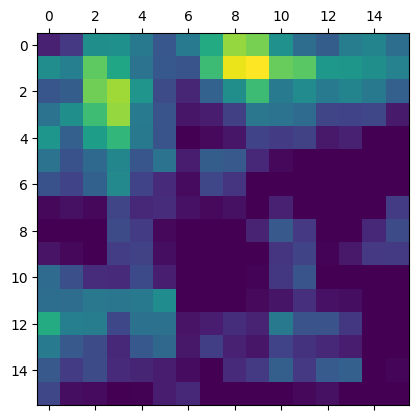

In [ ]:
gradcam_heatmap = visualize_heatmap(heatmap)
plt.matshow(gradcam_heatmap)

In [ ]:
def visualize_activation_map(heatmap,dim):
  if isinstance(heatmap, torch.Tensor):
    heatmap = heatmap.cpu().numpy()
  heatmap = cv.resize(heatmap, (dim[1],dim[2]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv.applyColorMap(heatmap,cv.COLORMAP_JET)
  return heatmap

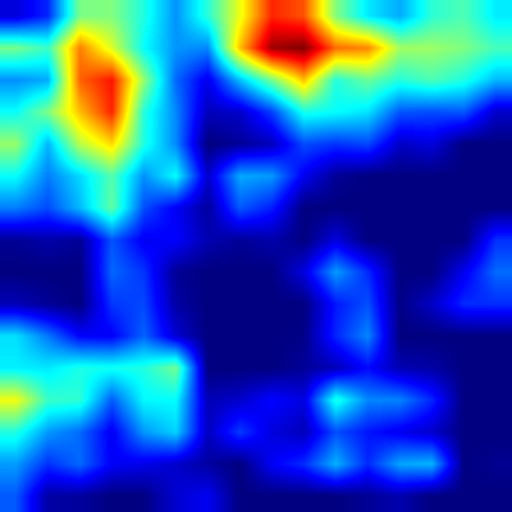

In [ ]:
gradcam_activation_map = visualize_activation_map(gradcam_heatmap,dim)
cv2_imshow(gradcam_activation_map)

In [ ]:
def visualize_superimposed(activation_map,img_path,dim):
  img = cv.imread(img_path)
  img = cv.resize(img,(dim[1],dim[2]))
  superimposed_img = activation_map*0.3 + img*0.7
  return superimposed_img

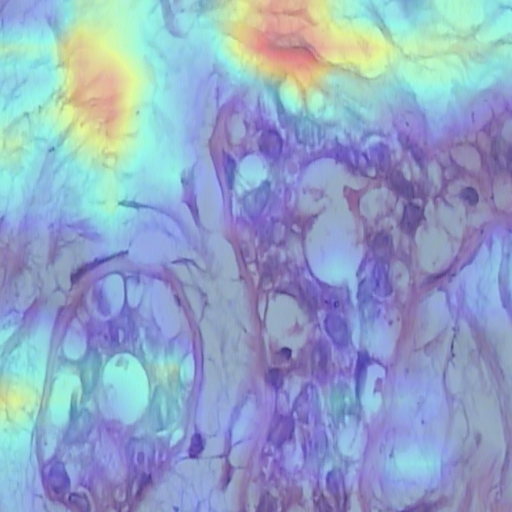

In [ ]:
gradcam_superimposed = visualize_superimposed(gradcam_activation_map,img_path,dim)
cv2_imshow(gradcam_superimposed)

<h3>Guided Backpropagation</h3>

In [ ]:
#!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git

In [ ]:
from pytorch_grad_cam.utils.find_layers import replace_all_layer_type_recursive
from torch.autograd import Function

In [ ]:
img = Image.open(img_path)

In [ ]:
class GuidedBackpropReLU(Function):
  @staticmethod
  def forward(self,input_img):
    positive_mask = (input_img>0).type_as(input_img)
    output = torch.addcmul(
        torch.zeros(input_img.size()).type_as(input_img),input_img,positive_mask)
    self.save_for_backward(input_img,output)
    return output

  @staticmethod
  def backward(self,grad_output):
    input_img,output = self.saved_tensors
    grad_input = None
    positive_mask1 = (input_img>0).type_as(grad_output)
    positive_mask2 = (grad_output>0).type_as(grad_output)
    grad_input = torch.addcmul(
        torch.zeros(input_img.size()).type_as(input_img),torch.addcmul(torch.zeros(input_img.size()).type_as(input_img),grad_output,positive_mask1),positive_mask2)
    return grad_input

In [ ]:
class GuidedBackpropReLUasModule(torch.nn.Module):
    def __init__(self):
        super(GuidedBackpropReLUasModule, self).__init__()

    def forward(self, input_img):
        return GuidedBackpropReLU.apply(input_img)

In [ ]:
class GuidedBackpropReLUModel:
  def __init__(self, model, use_cuda):
        self.model = model
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = self.model.cuda()

  def forward(self,input_img):
    return self.model(input_img)

  def recursive_replace_relu_with_guidedrelu(self, module_top):
         for idx, module in module_top._modules.items():
             self.recursive_replace_relu_with_guidedrelu(module)
             if module.__class__.__name__ == 'ReLU':
                 module_top._modules[idx] = GuidedBackpropReLU.apply
         print("b")

  def recursive_replace_guidedrelu_with_relu(self, module_top):
        try:
            for idx, module in module_top._modules.items():
                self.recursive_replace_guidedrelu_with_relu(module)
                if module == GuidedBackpropReLU.apply:
                    module_top._modules[idx] = torch.nn.ReLU()
        except BaseException:
            pass

  def __call__(self, input_img, target_category=None):
        replace_all_layer_type_recursive(self.model,
                                         torch.nn.ReLU,
                                         GuidedBackpropReLUasModule())

        if self.cuda:
            input_img = input_img.cuda()

        input_img = input_img.requires_grad_(True)

        output = self.forward(input_img)

        if target_category is None:
            target_category = np.argmax(output.cpu().data.numpy())

        loss = output[0, target_category]
        loss.backward(retain_graph=True)

        output = input_img.grad.cpu().data.numpy()
        output = output[0, :, :, :]
        output = output.transpose((1, 2, 0))

        replace_all_layer_type_recursive(self.model,
                                         GuidedBackpropReLUasModule,
                                         torch.nn.ReLU())

        return output

In [ ]:
guided_backprop_model = GuidedBackpropReLUModel(model=mobilenet_model,use_cuda=False)

In [ ]:
def guided_backprop_output(model,img):
  X = transform(img)
  X.unsqueeze_(0)
  X = X.to(device)
  preds = model.forward(X)
  _, predicted_class = preds.max(1)
  print("Predicted Class:", classes[predicted_class.item()])
  guided_backprop_output = guided_backprop_model(X, target_category=predicted_class.item())

  return guided_backprop_output

In [ ]:
guided_backprop_output = guided_backprop_output(guided_backprop_model,img)

Predicted Class: Benign


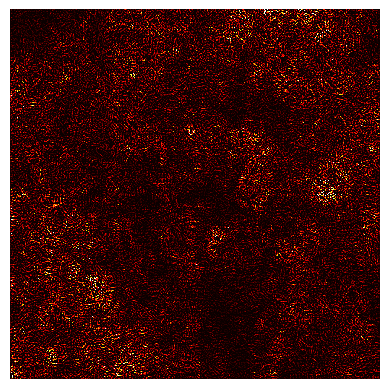

In [ ]:
guided_backprop_activation_map = np.mean(guided_backprop_output, axis=-1)
plt.imshow(guided_backprop_activation_map, cmap='hot', vmin=0, vmax=np.percentile(guided_backprop_activation_map, 99))
plt.axis('off')
plt.show()

In [ ]:
def visualize_activation_map_ggbp(heatmap,dim,img_path):
  if isinstance(heatmap, torch.Tensor):
    heatmap = heatmap.cpu().numpy()
  heatmap = cv.resize(heatmap, (dim[1],dim[2]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv.applyColorMap(heatmap,cv.COLORMAP_PLASMA) #Changed from JET to PLASMA
  img = cv.imread(img_path)
  img = cv.resize(img,(dim[1],dim[2]))
  superimposed_img = heatmap*0.6 + img*0.5
  return superimposed_img,heatmap

In [ ]:
guided_backprop_superimposed, guided_backprop_am = visualize_activation_map_ggbp(guided_backprop_activation_map,dim,img_path)

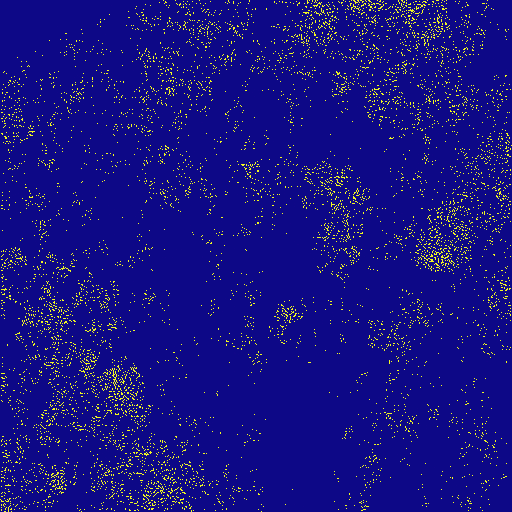

In [ ]:
cv2_imshow(guided_backprop_am)

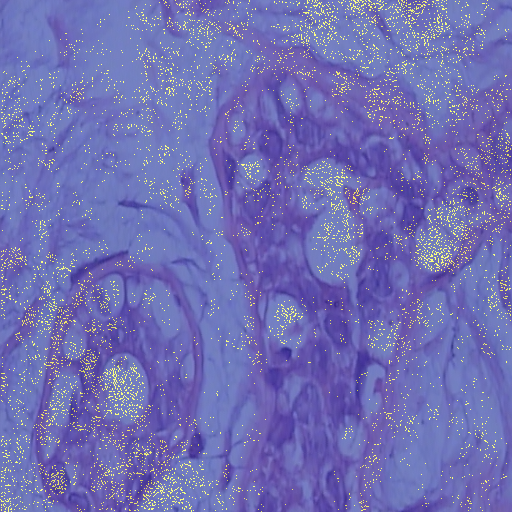

In [ ]:
cv2_imshow(guided_backprop_superimposed)

<h3> Guided GradCAM </h3>

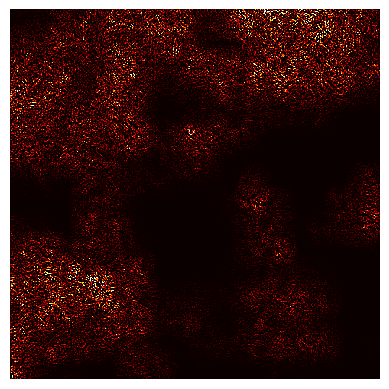

In [ ]:
gradcam_sum = np.sum(gradcam_activation_map, axis=-1) #Convert heatmap to grayscale
normalized_gradcam_sum = (gradcam_sum - gradcam_sum.min()) / (gradcam_sum.max() - gradcam_sum.min() + 1e-8)
guided_gradcam_activation_map = normalized_gradcam_sum * guided_backprop_activation_map
plt.imshow(guided_gradcam_activation_map, cmap='hot', vmin=0, vmax=np.percentile(guided_gradcam_activation_map, 99))
plt.axis('off')
plt.show()

In [ ]:
guided_gradcam_superimposed, guided_gradcam_am = visualize_activation_map_ggbp(guided_gradcam_activation_map,dim,img_path)

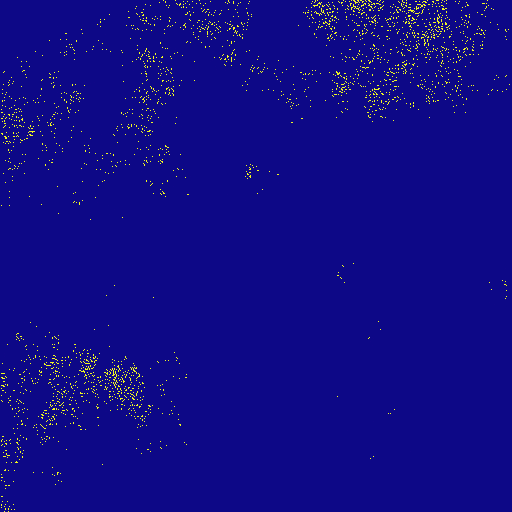

In [ ]:
cv2_imshow(guided_gradcam_am)

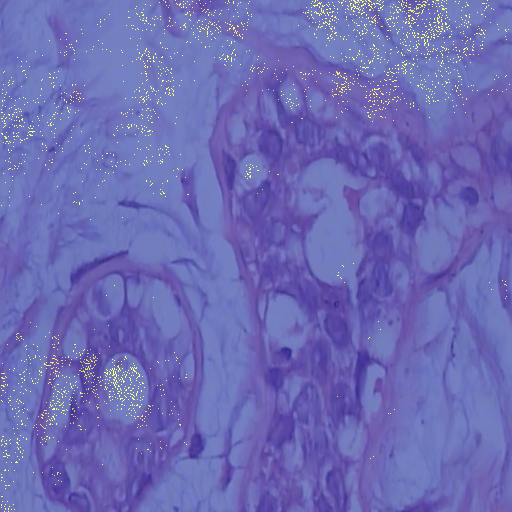

In [ ]:
cv2_imshow(guided_gradcam_superimposed)

<h3> Saliency Maps </h3>

In [ ]:
img = Image.open(img_path)

In [ ]:
def saliency_maps_generate(img,model):
  model.eval()

  X = transform(img)
  X.unsqueeze_(0)
  X = X.to(device)
  X.requires_grad_()

  logits = model(X)
  scores_max_index = logits.argmax()
  print("Predicted Class: ", classes[scores_max_index.item()])

  score_max = logits[:, scores_max_index.item()]
  score_max.backward()

  saliency, _ = torch.max(X.grad.data.abs(), dim=1)
  saliency.squeeze_(0)

  return saliency

In [ ]:
saliency_activation_map = saliency_maps_generate(img,mobilenet_model)

Predicted Class:  Benign


In [ ]:
saliency_activation_map = saliency_activation_map.to('cpu')

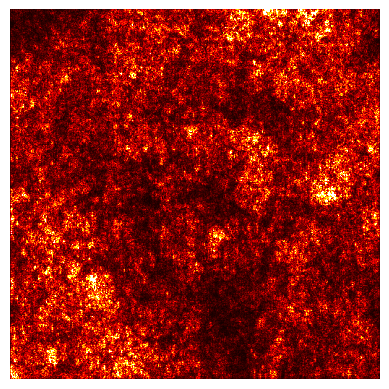

In [ ]:
plt.imshow(saliency_activation_map, cmap='hot', vmin=0, vmax=np.percentile(saliency_activation_map, 99))
plt.axis('off') #sets min value of color scale to 0 and maximum value to 99th percentile of the heatmap
plt.show()

In [ ]:
def visualize_activation_map_ggbp(heatmap,dim,img_path):
  if isinstance(heatmap, torch.Tensor):
    heatmap = heatmap.cpu().numpy()
  heatmap = cv.resize(heatmap, (dim[1],dim[2]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv.applyColorMap(heatmap,cv.COLORMAP_JET)
  img = cv.imread(img_path)
  img = cv.resize(img,(dim[1],dim[2]))

  superimposed_img = heatmap*0.6 + img*0.5
  return superimposed_img,heatmap
saliency_superimposed, saliency_am = visualize_activation_map_ggbp(saliency_activation_map,dim,img_path)

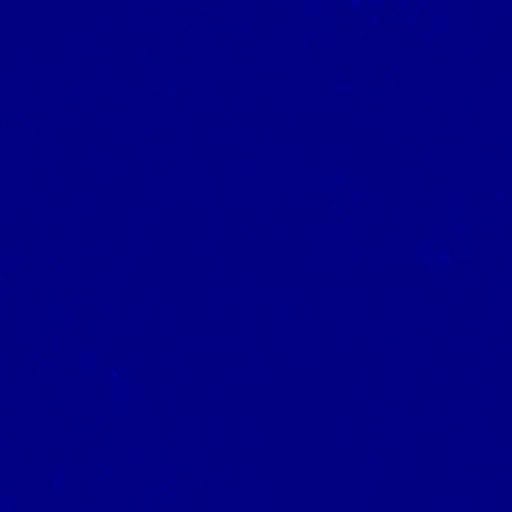

In [ ]:
cv2_imshow(saliency_am)

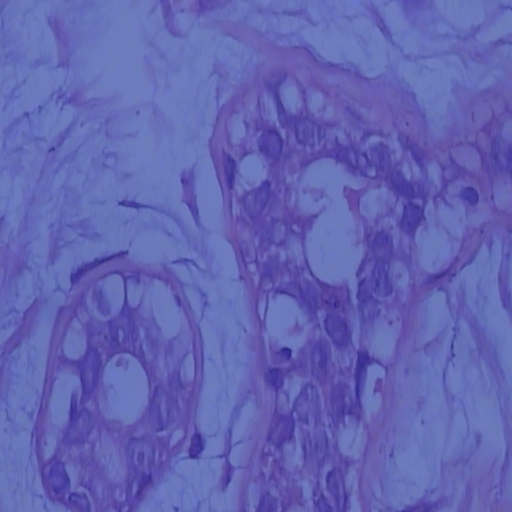

In [ ]:
cv2_imshow(saliency_superimposed)

<h2>GradCAM Plus Plus</h2>

In [ ]:
img_path

'/content/SOB_B_A-14-29960CD-400-012.png'

In [ ]:
img = Image.open(img_path)

In [ ]:
def GradCAMPP(img,transform,model):
  X = transform(img)
  X.unsqueeze_(0)
  X = X.to(device)

  b, c, h, w = X.size()
  logits = model(X)
  _,index = torch.max(logits,dim=1)
  print("Predicted Label:", classes[index[0]])
  score = logits[:,index[0].item()]
  score.backward()
  gradients = model.get_gradients()
  activations = model.get_featuremaps(X).detach()
  b, k, u, v = gradients.size()

  alpha_num = gradients.pow(2)
  alpha_denom = gradients.pow(2).mul(2) + activations.mul(gradients.pow(3)).view(b, k, u*v).sum(-1, keepdim=True).view(b, k, 1, 1)
  alpha_denom = torch.where(alpha_denom != 0.0, alpha_denom, torch.ones_like(alpha_denom))

  alpha = alpha_num.div(alpha_denom+1e-7)
  positive_gradients = F.relu(score.exp()*gradients) # ReLU(dY/dA) == ReLU(exp(S)*dS/dA))
  weights = (alpha*positive_gradients).view(b, k, u*v).sum(-1).view(b, k, 1, 1)

  saliency_map = (weights*activations).sum(1, keepdim=True)
  saliency_map = F.relu(saliency_map)
  saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
  saliency_map = (saliency_map-saliency_map_min).div(saliency_map_max-saliency_map_min).data

  saliency_map = torch.mean(saliency_map, dim=1).squeeze()

  return saliency_map

In [ ]:
heatmap_gradcampp = GradCAMPP(img,transform, mobilenet)

Predicted Label: Benign


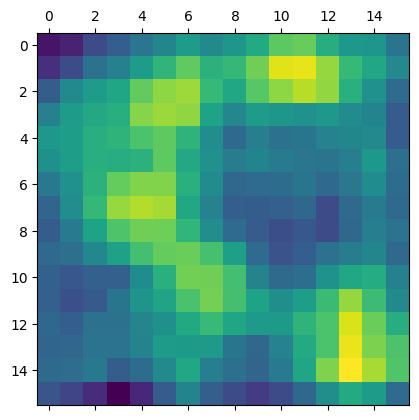

In [ ]:
heatmap_gradcampp = heatmap_gradcampp.cpu()
plt.matshow(heatmap_gradcampp)

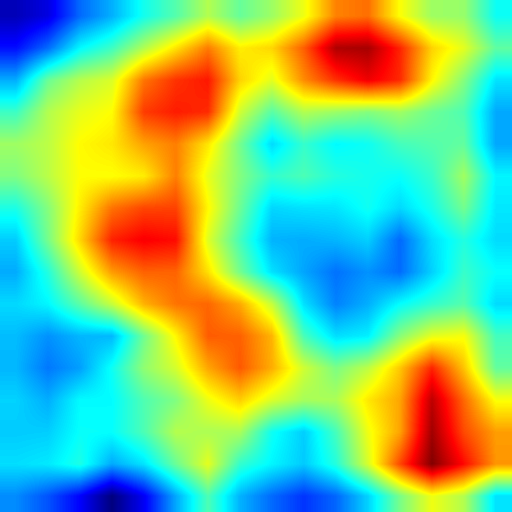

In [ ]:
gradcampp_activation_map = visualize_activation_map(heatmap_gradcampp,dim)
cv2_imshow(gradcampp_activation_map)

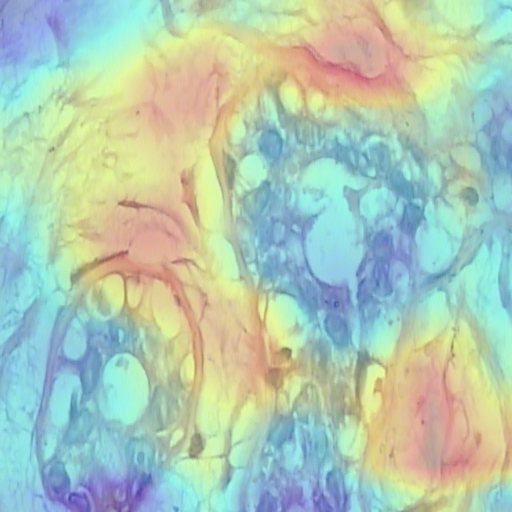

In [ ]:
gradcampp_superimposed = visualize_superimposed(gradcampp_activation_map,img_path,dim)
cv2_imshow(gradcampp_superimposed)

<h2> Visualization </h2>

In [ ]:
import cv2

In [ ]:
def process_image(img_path):
  img = cv2.imread(img_path)
  img = cv2.resize(img, (dim[1], dim[2]))
  return img

In [ ]:
img = process_image(img_path)

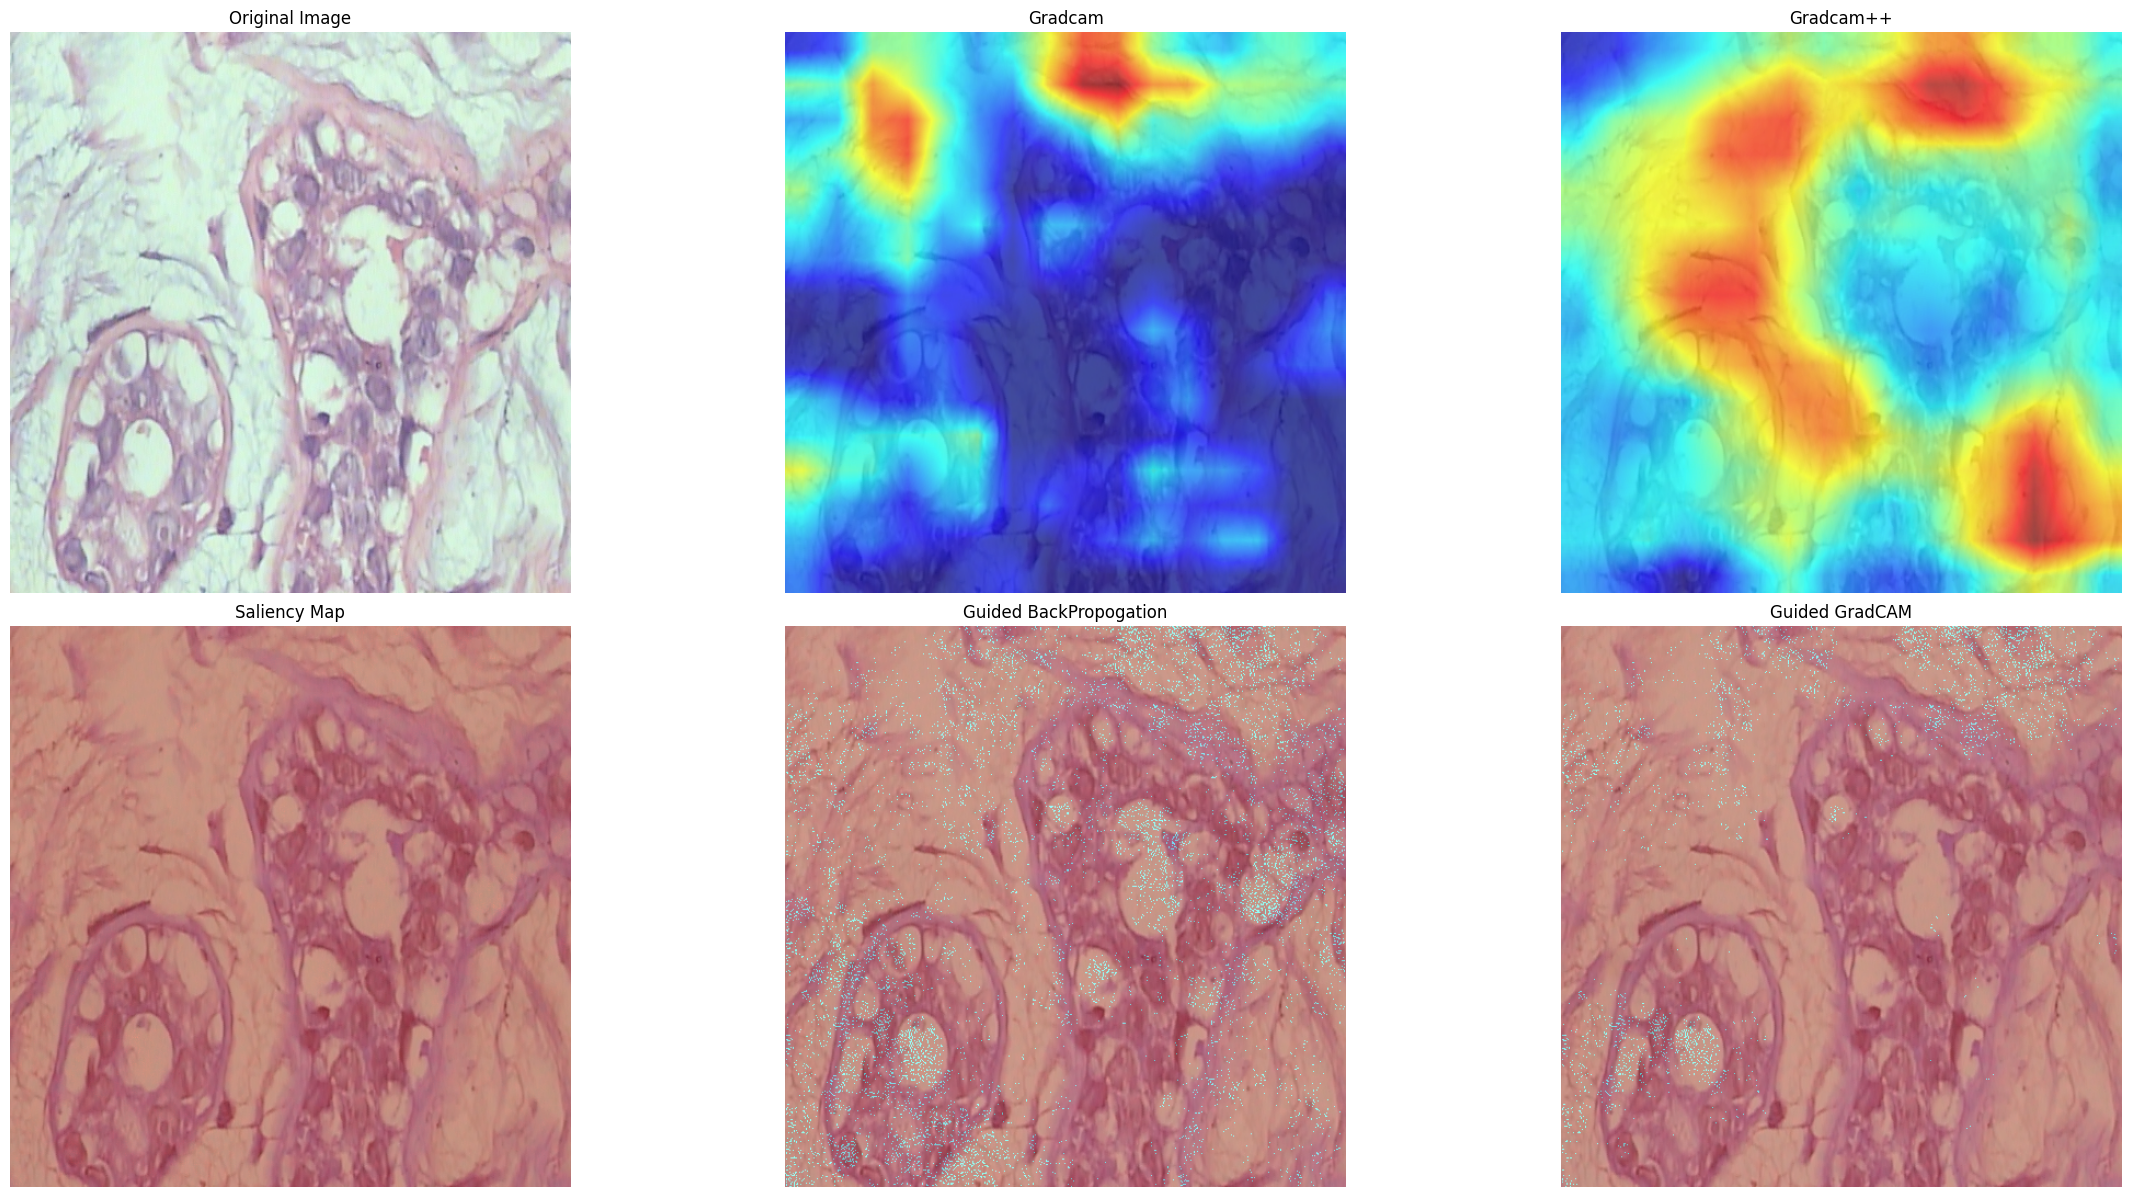

In [ ]:
fig, axs = plt.subplots(2,3, figsize=(30,15))


img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

superimposed_img = cv2.addWeighted(img, 0.3, gradcam_activation_map, 0.7, 0)
superimposed_img1 = cv2.addWeighted(img, 0.3, gradcampp_activation_map,0.7,0)
superimposed_img2 = cv2.addWeighted(img, 0.6, saliency_am,0.5,0)
superimposed_img3 = cv2.addWeighted(img, 0.6, guided_backprop_am,0.5,0)
superimposed_img4 = cv2.addWeighted(img, 0.6, guided_gradcam_am,0.5,0)


axs[0, 0].imshow(img_rgb)
axs[0, 0].set_title('Original Image')
axs[0, 0].axis('off')

axs[0,1].imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
axs[0,1].set_title('Gradcam')
axs[0,1].axis('off')

axs[0,2].imshow(cv2.cvtColor(superimposed_img1, cv2.COLOR_BGR2RGB))
axs[0,2].set_title('Gradcam++')
axs[0,2].axis('off')


axs[1,0].imshow(superimposed_img2, cmap=plt.cm.hot)
axs[1,0].set_title('Saliency Map')
axs[1,0].axis('off')


axs[1,1].imshow(superimposed_img3)
axs[1,1].set_title("Guided BackPropogation")
axs[1,1].axis("off")

axs[1,2].imshow(superimposed_img4)
axs[1,2].set_title('Guided GradCAM')
axs[1,2].axis('off')

plt.subplots_adjust(wspace=0.001, hspace = 0.06)
plt.show()

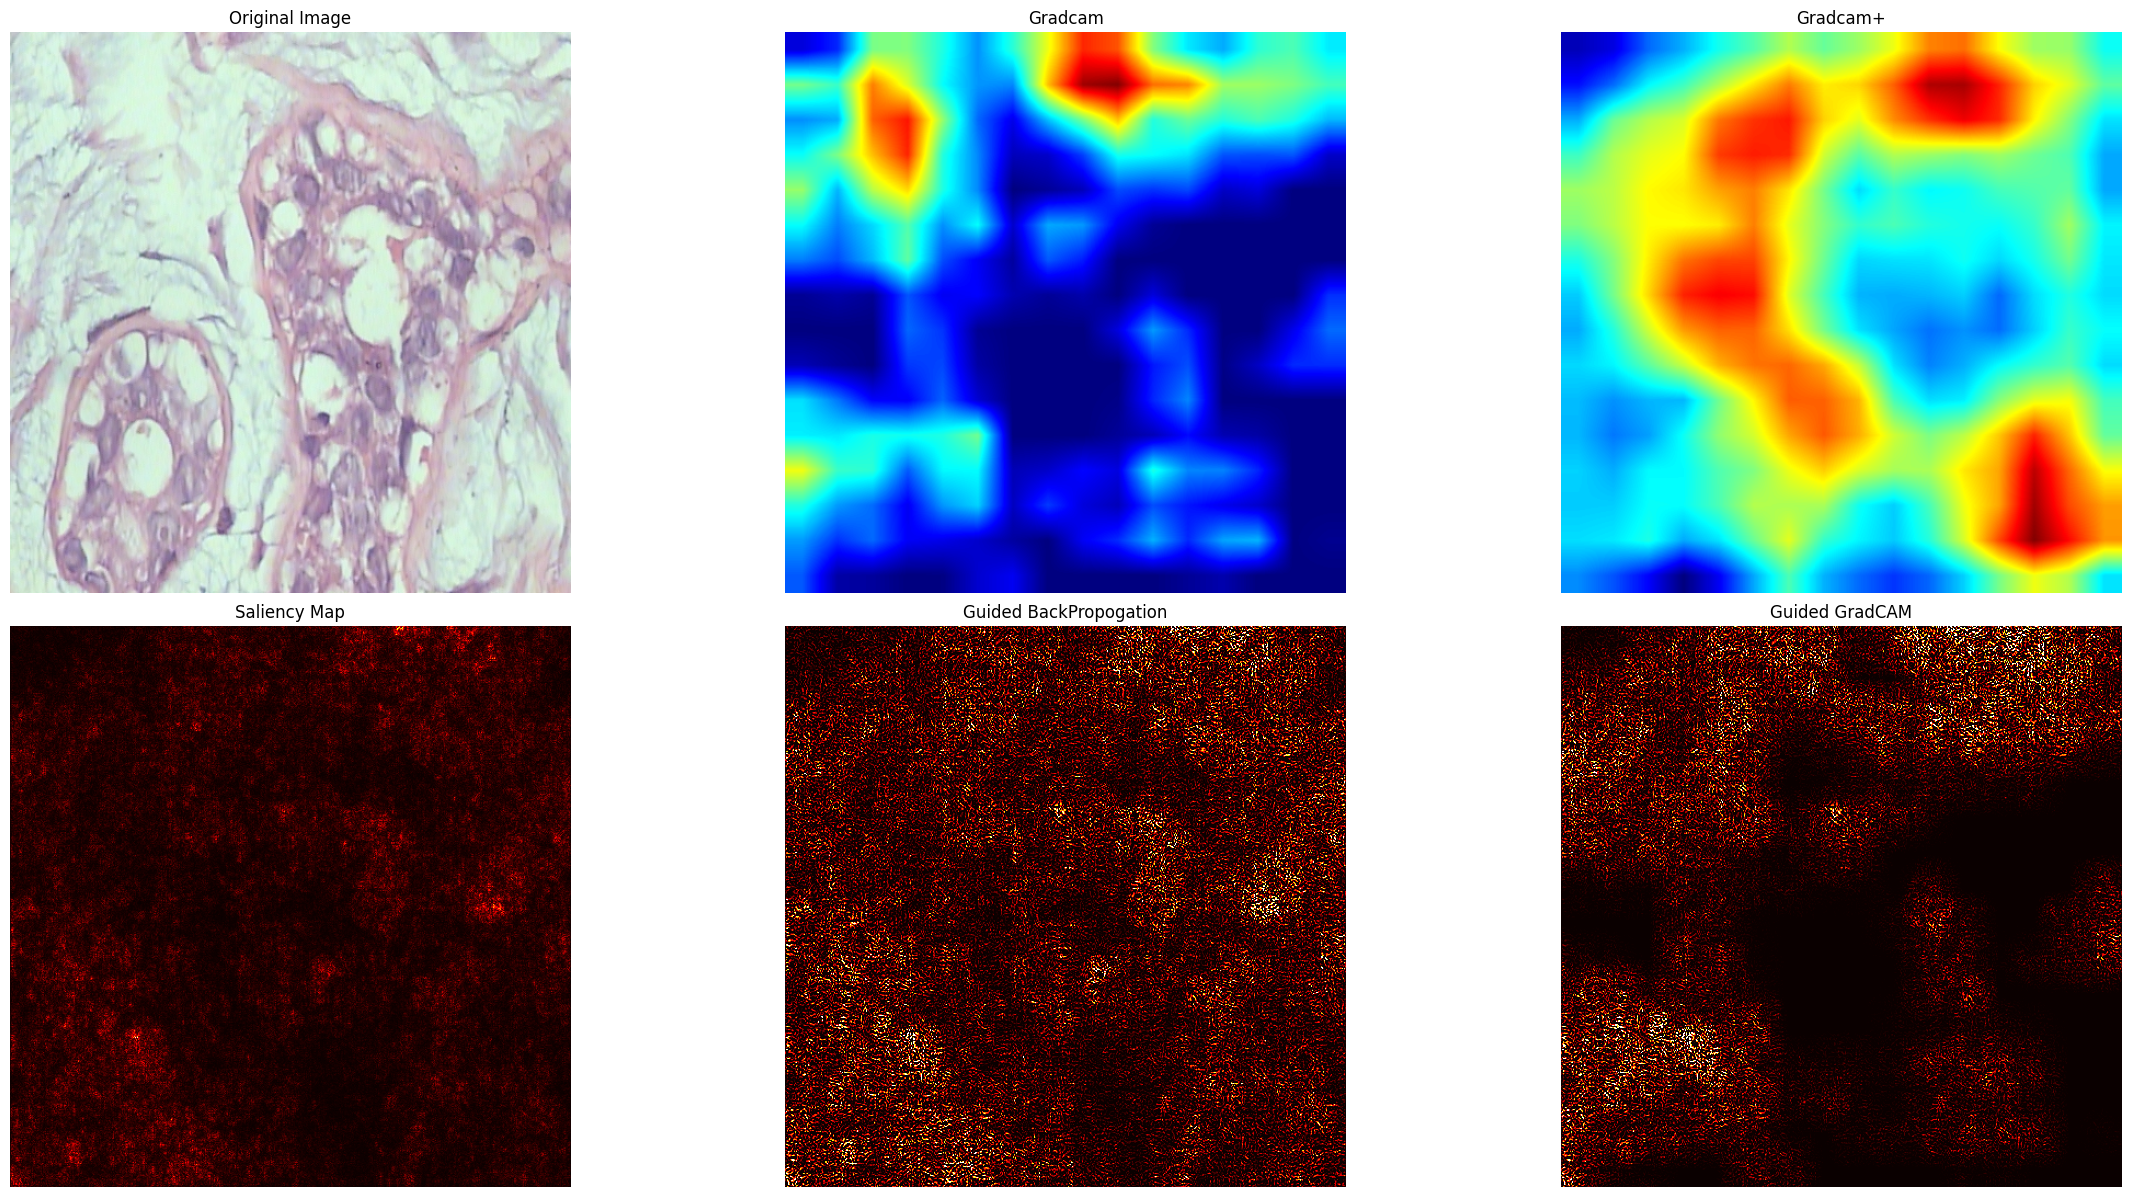

In [ ]:
fig, axs = plt.subplots(2,3, figsize=(30,15))

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


axs[0, 0].imshow(img_rgb)
axs[0, 0].set_title('Original Image')
axs[0, 0].axis('off')

axs[0,1].imshow(cv2.cvtColor(gradcam_activation_map, cv2.COLOR_BGR2RGB))
axs[0,1].set_title('Gradcam')
axs[0,1].axis('off')

axs[0,2].imshow(cv2.cvtColor(gradcampp_activation_map, cv2.COLOR_BGR2RGB))
axs[0,2].set_title('Gradcam+')
axs[0,2].axis('off')


axs[1,0].imshow(saliency_activation_map, cmap=plt.cm.hot)
axs[1,0].set_title('Saliency Map')
axs[1,0].axis('off')


axs[1,1].imshow(guided_backprop_activation_map, cmap='hot', vmin=0, vmax=np.percentile(guided_backprop_activation_map, 99))
axs[1,1].set_title("Guided BackPropogation")
axs[1,1].axis("off")

axs[1,2].imshow(guided_gradcam_activation_map, cmap='hot', vmin=0, vmax=np.percentile(guided_gradcam_activation_map, 99))
axs[1,2].set_title('Guided GradCAM')
axs[1,2].axis('off')

plt.subplots_adjust(wspace=0.001, hspace = 0.06)
plt.show()

In [ ]:
img_path

'/content/SOB_B_A-14-29960CD-400-012.png'